In [33]:
import numpy as np
import pandas as pd
import seaborn as sns

from datetime import datetime
from sklearn.preprocessing import MinMaxScaler

import networkx as nx

import MeCab
mecab = MeCab.Tagger (r"-Ochasen -u ../data/ref/user_keyakizaka.dic")

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
# %matplotlib inline
import matplotlib.font_manager as fm
fm.findSystemFonts()
font = {"family":"IPAexGothic"}
mpl.rc('font', **font)

In [3]:
def get_member_words( text ):
    tokens = []
    result = mecab.parseToNode( text )
    while result:
        line = result.feature.split(',')
        tag = line[-1]
        if 'keyakizaka' in tag:
            tokens.append( [result.surface, tag] )
        result = result.next
    return tokens

In [4]:
def extract_df_date_range(df_tmp, start, end):
    df_tmp['datetime'] = pd.to_datetime( df_tmp['datetime'], format='%Y/%m/%d%H:%M' )
    df_tmp = df_tmp.set_index('datetime')
    df_tmp = df_tmp.loc[start:end]
    return df_tmp

In [104]:
def get_relation( df  ): 
    mat = np.zeros( ( len(target_members), len(target_members)) )
    for i, t in enumerate( df[['author', 'text']].values.tolist()):    
        memtags = get_member_words(t[1])
        if len( memtags ) == 0: continue
        atag = author2tag[t[0]]
        memtags_rm = [ i[1] for i in memtags if i[1] != atag]
        for inmem in memtags_rm:
            if not inmem in target_members: continue
            mat[mem2idx[atag], mem2idx[inmem]] += 1.0
    
    dfmat = pd.DataFrame( mat, index=target_members_name, columns=target_members_name )
    dfmat.index.name = 'from'
    dfmat.columns.name = 'to'
    return dfmat

In [98]:
def mms_for_df( df ):
    mms = MinMaxScaler()
    df_mms = pd.DataFrame( mms.fit_transform( df.T ).T, index=target_members_name, columns=target_members_name )
    df_mms.index.name = 'from'
    df_mms.columns.name = 'to'
    return df_mms

def chech_heatmap(df):
    plt.figure( figsize=(12, 9), dpi=100 ) 
    sns.heatmap(df, annot=True, fmt="1.2f", linewidths=.5, cmap="Oranges")
    plt.show()
    return

In [129]:
# gdf file ( Gephi )
def get_gdf_from_networkX( G, fpath ):
    f = open( fpath, 'w', encoding='shift-jis', errors='ignore' )
    # node
    f.write( 'nodedef>name VARCHAR,label VARCHAR,\n')
    name2idx = { name:i for i, name in enumerate( G.nodes )}
    for i, name in enumerate( G.nodes ):
        f.write('%d,%s,\n' % ( i, name ) )

    # edge
    f.write( 'edgedef>node1 VARCHAR,node2 VARCHAR,weight DOUBLE\n' )
    for e in G.edges(data=True):
        f.write('%d,%d,%.3f\n' % (name2idx[e[0]], name2idx[e[1]], e[2]['weight']) )
    f.close()
    
# gml file ( cytoscape )    
def get_gml_from_networkX( G, fpath ):
    f = open( fpath, 'w', encoding='utf-8', errors='ignore' )
    f.write('graph [')
    # node
    name2idx = { name:i for i, name in enumerate( G.nodes )}
    for name, i in name2idx.items():
        f.write('''
          node [
            id %d
            label "%s"
          ]'''
        % ( i, name ))
    
    # edge
    for e in G.edges(data=True):
        f.write('''
          edge [
            source %d
            target %d
            weight %.3f
          ]'''
        % (name2idx[e[0]], name2idx[e[1]], e[2]['weight']) )  
    
    f.write('\n]')
    f.close()   

In [153]:
# read blog data

df = pd.read_csv( '../data/keyakizaka46_blog.csv' )
print( df.shape )
df.head(1) 

(16367, 6)


,author,datetime,title,text,images,url
0,石森虹花,2015/11/1323:43,ん〜〜。。。寝れない(つД`)ノ,\r\n\r\n\r\nみんなさんこんばんわ!\r\n\r\n欅坂46 石森虹花です U・x...,http://cdn.keyakizaka46.com/images/14/c47/4b13...,http://www.keyakizaka46.com/s/k46o/diary/detai...


In [156]:
author2tag = {}
for i in df.head(500)['author'].unique().tolist(): # 漢字欅だけにしたいので500件のみ, 卒業メンバ含まない18名
    memwords = get_member_words(i)
    if len(memwords) == 0: continue
    author2tag[i] = memwords[0][1]
target_members_name = [ i for i in author2tag.keys() ]
target_members = [ i for i in author2tag.values() ]
mem2idx = { mem:idx for idx,mem in enumerate( target_members ) }

In [157]:
df_kanji = df[df['author'].isin( target_members_name )]

In [158]:
df_kanji_targetrange = extract_df_date_range(df_kanji, '2015-01-01', '2019-04-01')
dfmat = get_relation( df_kanji_targetrange )
dfmat_mms = mms_for_df( dfmat )

C:\Users\myaun\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


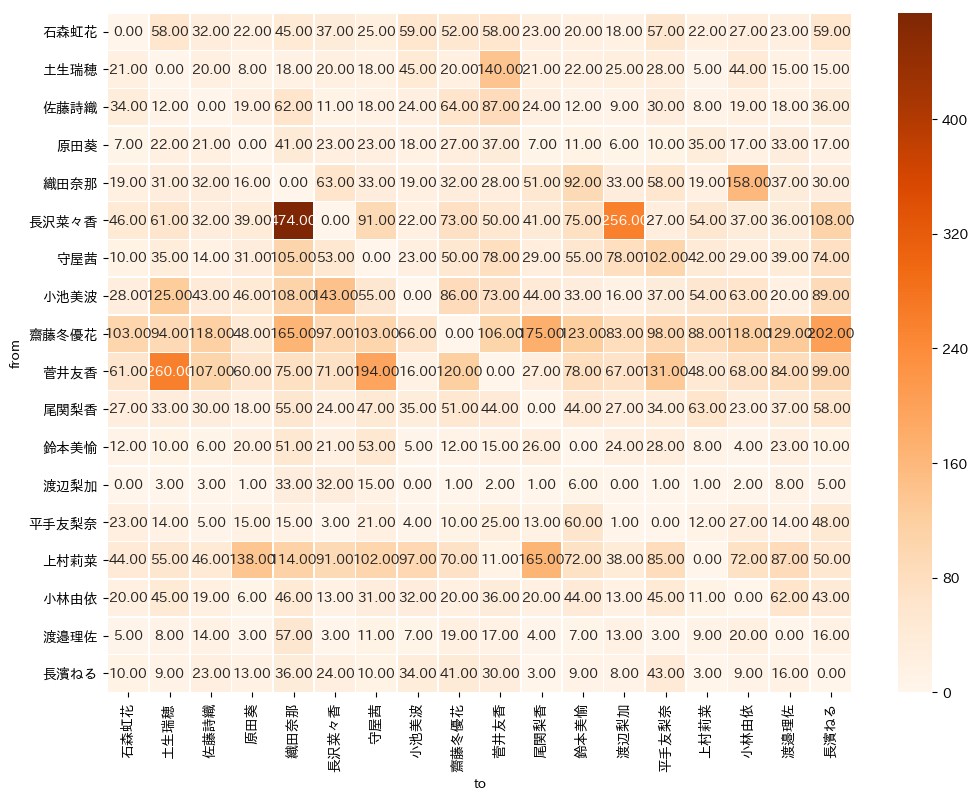

In [159]:
chech_heatmap(dfmat)

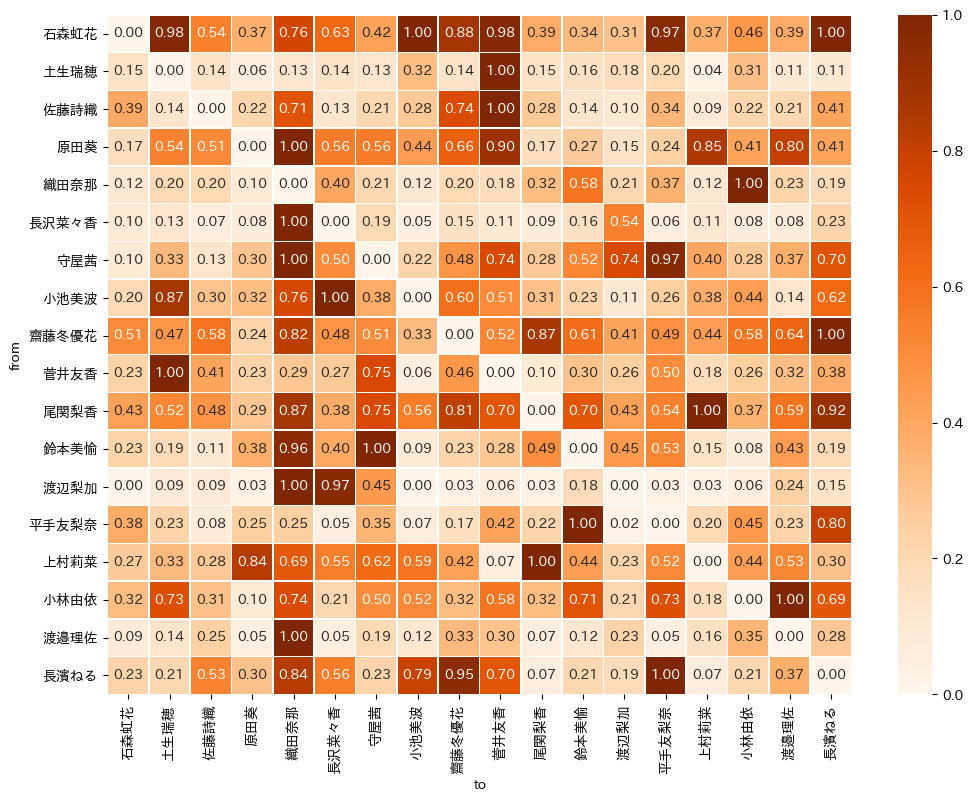

In [99]:
chech_heatmap(dfmat_mms)

In [141]:
# neighbor_num = 2
th = 0.8

targets = {}
for i in range( len( target_members ) ):
    mat = dfmat_mms.T.values
    sorted = np.argsort(mat[i])[::-1]
    sorted_val = np.sort(mat[i])[::-1]
    target = []
    for idx in range( len( sorted ) ):
        if sorted_val[idx] >= th:
            target.append( (sorted[idx], sorted_val[idx]) )
    targets[i] = target

In [160]:
targets = {}
for i in range( len( target_members ) ):
    mat = dfmat.values
    sorted = np.argsort(mat[i])[::-1]
    sorted_val = np.sort(mat[i])[::-1]
    target = []
    for idx in range( len( sorted ) ):
        target.append( (sorted[idx], sorted_val[idx]) )
    targets[i] = target

In [161]:
G = nx.DiGraph()
for i, target in targets.items() :
    for j in target:
        G.add_edge(target_members_name[i],
                   target_members_name[j[0]],
                   weight=j[1])

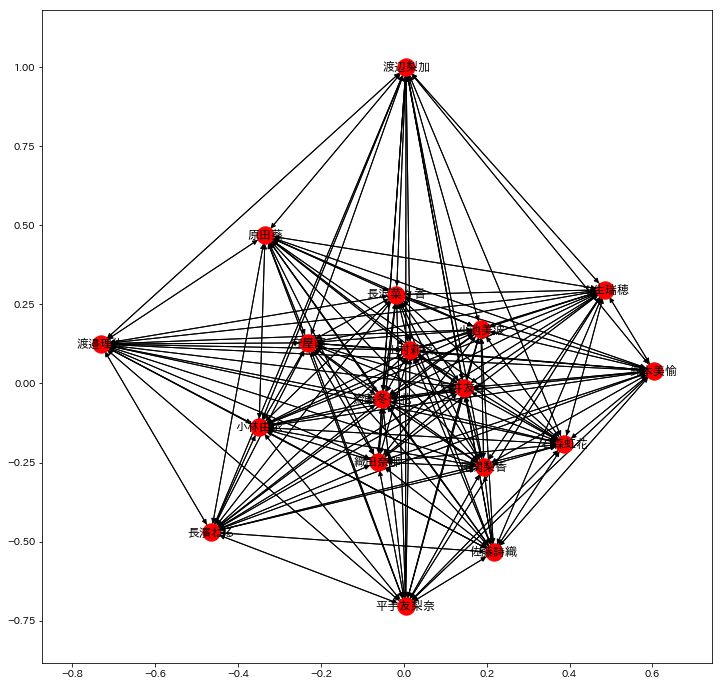

In [151]:
plt.figure(figsize=(12, 12))
nx.draw_networkx(G, font_family='IPAexGothic')
plt.show()

In [162]:
get_gdf_from_networkX( G, '../data/graph_Blog_test.gdf' )
get_gml_from_networkX( G, '../data/graph_Blog_test.gml' )